In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

In [7]:
# Load the datasets
constructors = pd.read_csv('constructors.csv')
drivers = pd.read_csv('drivers.csv')
lap_times = pd.read_csv('lap_times.csv')
qualifying = pd.read_csv('qualifying.csv')
races = pd.read_csv('races.csv')

# Merge lap times with races and drivers information
lap_times_merged = lap_times.merge(races[['raceId', 'year', 'name']], on='raceId', how='left')
lap_times_merged = lap_times_merged.merge(drivers[['driverId', 'driverRef']], on='driverId', how='left')

# Calculate average lap time for each driver and car combination in each race
avg_lap_times = lap_times_merged.groupby(['driverId', 'raceId'])['milliseconds'].mean().reset_index()
avg_lap_times = avg_lap_times.merge(races[['raceId', 'year', 'name']], on='raceId', how='left')
avg_lap_times = avg_lap_times.merge(drivers[['driverId', 'driverRef']], on='driverId', how='left')

# Merge with qualifying to get constructorId
avg_lap_times = avg_lap_times.merge(qualifying[['driverId', 'raceId', 'constructorId']], on=['driverId', 'raceId'], how='left')

# Merge with constructors to get constructorRef
avg_lap_times = avg_lap_times.merge(constructors[['constructorId', 'constructorRef']], on='constructorId', how='left')

# Rank drivers based on their average lap times in each race
avg_lap_times['rank'] = avg_lap_times.groupby('raceId')['milliseconds'].rank()
# Sort by raceId and rank for better readability
avg_lap_times = avg_lap_times.sort_values(by=['raceId', 'rank'])
avg_lap_times

# Save the resulting dataframe to a CSV file
avg_lap_times.to_csv('Driver_avglaptime_Positions.csv', index=False)

In [8]:
qualifying_df = pd.read_csv('qualifying.csv')

# Define a function to convert mm:ss.sss format to seconds
def convert_to_seconds(time_str):
    try:
        if isinstance(time_str, str) and time_str != '0:00:00':
            parts = time_str.split(':')
            if len(parts) == 3:
                minutes, seconds, milliseconds = parts
            elif len(parts) == 2:
                minutes, seconds = parts
                milliseconds = '0'
            else:
                return 0.0
            total_seconds = int(minutes) * 60 + int(seconds) + int(milliseconds) / 10
            return total_seconds
    except Exception as e:
        print(f"Error converting time: {time_str}, Error: {e}")
    return 0.0

# Apply the function to q1, q2, q3 columns
for col in ['q1', 'q2', 'q3']:
    qualifying_df[col] = qualifying_df[col].apply(convert_to_seconds)

# Extract the best qualifying lap time for each driver
qualifying_df['best_lap_time'] = qualifying_df[['q1', 'q2', 'q3']].replace(0.0, np.nan).min(axis=1, skipna=True)

# Convert best lap time to float
qualifying_df['best_lap_time'] = qualifying_df['best_lap_time'].astype(float)

# Apply the reduction for bottom 5 and 11th to 15th placed drivers in each race
def adjust_lap_times(df):
    bottom_5_index = df.tail(5).index
    mid_index = df.iloc[10:15].index
    
    df.loc[bottom_5_index, 'best_lap_time'] -= 0.55
    df.loc[mid_index, 'best_lap_time'] -= 0.35
    return df

# Apply the adjustment to each race
qualifying_df = qualifying_df.groupby('raceId').apply(adjust_lap_times).reset_index(drop=True)

# Keep relevant columns
qualifying_df = qualifying_df[['driverId', 'constructorId', 'raceId', 'best_lap_time']]
#print(qualifying_df.head(30))

# Calculate the average best lap time for each constructor in each race
constructor_avg_lap_time = qualifying_df.groupby(['raceId', 'constructorId'])['best_lap_time'].mean().reset_index()
constructor_avg_lap_time.rename(columns={'best_lap_time': 'avg_best_lap_time'}, inplace=True)

# Sort the values from least to highest for each race
constructor_avg_lap_time = constructor_avg_lap_time.sort_values(by=['raceId', 'avg_best_lap_time'])

# Display the sorted average best lap time for each constructor
print(constructor_avg_lap_time.head(20))

    raceId  constructorId  avg_best_lap_time
3     1098              9             89.750
2     1098              6             90.100
6     1098            131             90.350
5     1098            117             90.550
7     1098            210             91.075
4     1098             51             91.100
1     1098              3             91.150
9     1098            214             91.275
0     1098              1             91.300
8     1098            213             91.300
13    1099              9             88.375
12    1099              6             88.650
15    1099            117             88.800
16    1099            131             89.050
17    1099            210             89.200
14    1099             51             89.250
19    1099            214             89.250
18    1099            213             89.500
10    1099              1             89.525
11    1099              3            108.700


In [9]:
driver_avg_lap_times = pd.read_csv('Driver_avglaptime_Positions.csv')

# Merge the driver average lap times with the constructor average best lap times
combined_data = driver_avg_lap_times.merge(constructor_avg_lap_time[['raceId', 'constructorId', 'avg_best_lap_time']], on=['raceId', 'constructorId'], how='left')

# Identify the minimum avg_best_lap_time for each race
min_best_lap_time_per_race = constructor_avg_lap_time.groupby('raceId')['avg_best_lap_time'].min().reset_index()
min_best_lap_time_per_race.rename(columns={'avg_best_lap_time': 'min_best_lap_time'}, inplace=True)

# Merge the minimum best lap time with the combined data
combined_data = combined_data.merge(min_best_lap_time_per_race, on='raceId', how='left')

# Calculate the inverse adjustment factor for each constructor for each race
combined_data['inverse_adjustment_factor'] = combined_data['min_best_lap_time'] / combined_data['avg_best_lap_time']
combined_data = combined_data[['name', 'driverRef', 'avg_best_lap_time', 'inverse_adjustment_factor']]
combined_data.head(10)
# Adjust the avg_laptime for each driver
# combined_data['adjusted_avg_laptime'] = combined_data['avg_laptime'] * combined_data['inverse_adjustment_factor']
# combined_data = combined_data[['raceId', 'avg_laptime', 'year', 'name', 'driverRef', 'driverId','constructorRef','rank', 'inverse_adjustment_factor','adjusted_avg_laptime']]

# # Calculate the rank for each race based on adjusted_avg_laptime
# combined_data['rank'] = combined_data.groupby('raceId')['adjusted_avg_laptime'].rank(method='min')

# # Calculate DPS points
# def calculate_dps(rank):
#     return 21 - rank

# combined_data['DPS'] = combined_data['rank'].apply(calculate_dps)

# # Select and reorder relevant columns
# final_data = combined_data[['raceId', 'adjusted_avg_laptime', 'year', 'DPS', 'driverRef', 'driverId', 'constructorRef', 'rank', 'inverse_adjustment_factor', 'avg_laptime', 'name']]

# # Sort the final data by raceId and rank
# final_data = final_data.sort_values(by=['raceId', 'rank'])

#final_data.to_csv('FinalDPS.csv')

,name,driverRef,avg_best_lap_time,inverse_adjustment_factor
0,Bahrain Grand Prix,max_verstappen,89.750,1.000000
1,Bahrain Grand Prix,perez,89.750,1.000000
2,Bahrain Grand Prix,alonso,90.550,0.991165
3,Bahrain Grand Prix,leclerc,90.100,0.996115
4,Bahrain Grand Prix,sainz,90.100,0.996115
5,Bahrain Grand Prix,hamilton,90.350,0.993359
6,Bahrain Grand Prix,stroll,90.550,0.991165
7,Bahrain Grand Prix,russell,90.350,0.993359
8,Bahrain Grand Prix,bottas,91.100,0.985181
9,Bahrain Grand Prix,gasly,91.275,0.983292


In [10]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

# Load the dataset
data = pd.read_csv('historical_data.csv')

# Get the top 20 most frequently appearing drivers
top_drivers = data['driverRef'].value_counts().nlargest(20).index.tolist()

# Initialize DataFrame to store predictions
predictions_df = pd.DataFrame()

# Assuming the upcoming_races.csv is loaded with 'raceId'
upcoming_races = pd.DataFrame({'raceId': [1132, 1133, 1134, 1135, 1136, 1137, 1138, 1139, 1140, 1141, 1142, 1143, 1144]})

# Process each driver separately
for driver in top_drivers:
    # Select data for current driver
    driver_data = data[data['driverRef'] == driver]
    
    # Prepare features and target
    X = driver_data[['raceId']].values.reshape(-1, 1)  # Feature: raceId
    y = driver_data['rank'].values                     # Target: rank
    
    # Create and train the model
    model = LinearRegression()
    model.fit(X, y)
    
    # Predict ranks for upcoming races
    predicted_scores = model.predict(upcoming_races[['raceId']])

    # Append predictions for this driver to the predictions DataFrame
    driver_predictions = pd.DataFrame({
        'raceId': upcoming_races['raceId'],
        'driverRef': [driver] * len(upcoming_races),
        'predictedScore': predicted_scores
    })
    
    predictions_df = pd.concat([predictions_df, driver_predictions], ignore_index=True)

# Sorting predictions within each race by predictedScore to assign ranks inversely
predictions_df.sort_values(by=['raceId', 'predictedScore'], ascending=[True, True], inplace=True)
predictions_df['predictedRank'] = predictions_df.groupby('raceId').cumcount() + 1

# Display the predictions
print(predictions_df.tail(50))


     raceId        driverRef  predictedScore  predictedRank
153    1142            perez       12.559227             11
88     1142             zhou       13.244029             12
127    1142             ocon       13.533808             13
140    1142           stroll       13.901753             14
23     1142           alonso       14.534745             15
10     1142            gasly       15.408518             16
244    1142          tsunoda       15.913232             17
231    1142            albon       17.098547             18
257    1142        ricciardo       17.207374             19
179    1142         sargeant       17.313395             20
76     1143           norris       -1.329820              1
50     1143          russell        2.073442              2
115    1143          piastri        2.649823              3
37     1143   max_verstappen        4.187302              4
193    1143          leclerc        4.215378              5
219    1143            sainz        4.44

c:\Users\samyo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\samyo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\samyo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\samyo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\samyo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Us

In [11]:
from sklearn.linear_model import LinearRegression

# Load the dataset
data = pd.read_csv('historical_data.csv')

# Get the top 20 most frequently appearing drivers
top_drivers = data['driverRef'].value_counts().nlargest(20).index.tolist()

# Initialize DataFrame to store predictions
predictions_df = pd.DataFrame()

# Initialize DataFrame to store trends
trends_df = pd.DataFrame(columns=['driverRef', 'trend', 'slope'])

# Assuming the upcoming_races.csv is loaded with 'raceId'
upcoming_races = pd.DataFrame({'raceId': [1132, 1133, 1134, 1135, 1136, 1137, 1138, 1139, 1140, 1141, 1142, 1143, 1144]})

# Process each driver separately
for driver in top_drivers:
    # Select data for current driver
    driver_data = data[data['driverRef'] == driver]
    
    # Prepare features and target
    X = driver_data[['raceId']].values.reshape(-1, 1)  # Feature: raceId
    y = driver_data['rank'].values                     # Target: rank
    
    # Create and train the model
    model = LinearRegression()
    model.fit(X, y)
    
    # Predict ranks for upcoming races
    upcoming_race_ids = upcoming_races[['raceId']].values.reshape(-1, 1)
    predicted_scores = model.predict(upcoming_race_ids)

    # Append predictions for this driver to the predictions DataFrame
    driver_predictions = pd.DataFrame({
        'raceId': upcoming_races['raceId'],
        'driverRef': [driver] * len(upcoming_races),
        'predictedScore': predicted_scores
    })
    
    predictions_df = pd.concat([predictions_df, driver_predictions], ignore_index=True)

    # Determine trend based on the slope of the predicted scores
    trend_model = LinearRegression()
    trend_model.fit(upcoming_race_ids, predicted_scores)
    slope = trend_model.coef_[0]
    
    # Classify trend
    if slope < -0.1:
        trend = 'Improving'
    elif slope > 0.1:
        trend = 'Declining'
    else:
        trend = 'Steady'
    
    # Append trend information using pd.concat
    trend_info = pd.DataFrame({'driverRef': [driver], 'trend': [trend], 'slope': [slope]})
    trends_df = pd.concat([trends_df, trend_info], ignore_index=True)

# Sorting predictions by raceId and predictedRank for better readability
predictions_df.sort_values(by=['raceId', 'predictedScore'], ascending=[True, True], inplace=True)
predictions_df['predictedRank'] = predictions_df.groupby('raceId').cumcount() + 1

# Display the predictions
predictions_df.to_csv("predictions.csv")

# Display the trends with slope values
trends_df.to_csv("driver_trends.csv")


C:\Users\samyo\AppData\Local\Temp\ipykernel_17296\3083113180.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  trends_df = pd.concat([trends_df, trend_info], ignore_index=True)


C:\Users\samyo\AppData\Local\Temp\ipykernel_17296\3411942424.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['driverName'] = filtered_data['driverId'].map(driver_names)


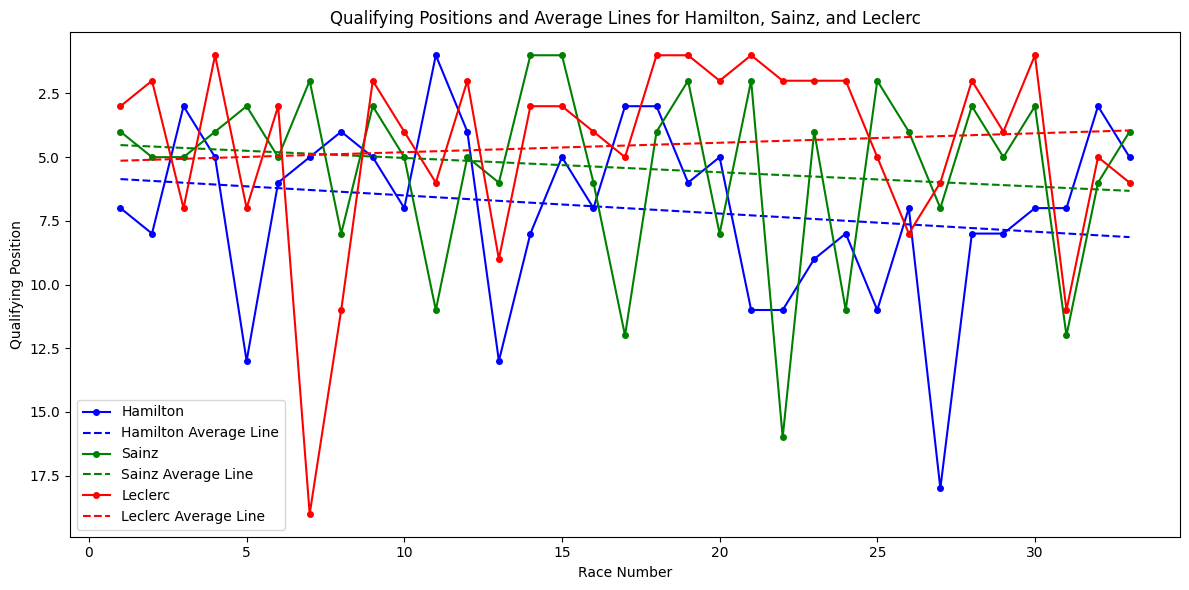

In [12]:
import matplotlib.pyplot as plt

# Load the qualifying data
qualifying_data = pd.read_csv('qualifying.csv')  # Update with your file path

# Filter data for Hamilton, Sainz, and Leclerc
driver_ids = [1, 832, 844]
filtered_data = qualifying_data[qualifying_data['driverId'].isin(driver_ids)]

# Map driver IDs to names for better readability
driver_names = {1: 'Hamilton', 832: 'Sainz', 844: 'Leclerc'}
filtered_data['driverName'] = filtered_data['driverId'].map(driver_names)

# Create a pivot table to organize the data
pivot_data = filtered_data.pivot(index='raceId', columns='driverName', values='position')

# Replace race IDs with race numbers starting from 1
pivot_data.reset_index(drop=True, inplace=True)
pivot_data.index = np.arange(1, len(pivot_data) + 1)

# Define colors for the drivers
driver_colors = {
    'Hamilton': 'blue',
    'Sainz': 'green',
    'Leclerc': 'red'
}

# Plot the data with smaller dots and trend lines
plt.figure(figsize=(12, 6))

for driver in driver_names.values():
    # Plotting the line graph with smaller dot points
    plt.plot(pivot_data.index, pivot_data[driver], marker='o', markersize=4, label=driver, color=driver_colors[driver])
    
    # Adding a trend line (average line)
    z = np.polyfit(pivot_data.index, pivot_data[driver], 1)
    p = np.poly1d(z)
    trend_label = f'{driver} Average Line'
    plt.plot(pivot_data.index, p(pivot_data.index), linestyle='--', color=driver_colors[driver], label=trend_label)

plt.xlabel('Race Number')
plt.ylabel('Qualifying Position')
plt.title('Qualifying Positions and Average Lines for Hamilton, Sainz, and Leclerc')
plt.gca().invert_yaxis()  # Invert y-axis to have position 1 at the top
plt.legend()
plt.tight_layout()

# Save the plot
plt.savefig('Qualifying_Positions_Trends_Hamilton_Sainz_Leclerc.png')

# Display the plot
plt.show()


In [160]:
# Filter predictions data for the specific drivers
drivers_of_interest = ['sainz', 'leclerc', 'hamilton']
filtered_predictions = predictions[predictions['driverRef'].isin(drivers_of_interest)]

# Plotting the predicted ranks for the drivers
import matplotlib.pyplot as plt

# Plot settings
plt.figure(figsize=(14, 8))

# Carlos Sainz
sainz_predictions = filtered_predictions[filtered_predictions['driverRef'] == 'sainz']
plt.plot(sainz_predictions['raceId'], sainz_predictions['predictedRank'], marker='o', linestyle='--', color='green', label='Carlos Sainz')

# Charles Leclerc
leclerc_predictions = filtered_predictions[filtered_predictions['driverRef'] == 'leclerc']
plt.plot(leclerc_predictions['raceId'], leclerc_predictions['predictedRank'], marker='o', linestyle='--', color='red', label='Charles Leclerc')

# Lewis Hamilton
hamilton_predictions = filtered_predictions[filtered_predictions['driverRef'] == 'hamilton']
plt.plot(hamilton_predictions['raceId'], hamilton_predictions['predictedRank'], marker='o', linestyle='--', color='blue', label='Lewis Hamilton')

# Plot customization
plt.xlabel('Race ID')
plt.ylabel('Predicted DPS Rank')
plt.title('Predicted DPS Ranks for Carlos Sainz, Charles Leclerc, and Lewis Hamilton')
plt.gca().invert_yaxis()  # Invert y-axis to show rank 1 at the top
plt.legend()
plt.grid(False)
plt.show()



KeyError: 'driverRef'